In [2]:
# !pip install photutils

In [3]:
show = True

In [4]:
from astropy.io import fits 
base = "mydata"
science = base+"/toi4010_star/20_49_41/toi4010_star_00001.fits"
hdu = fits.open(science) 
data = hdu[0].data
print("Data Shape: ",data.shape)
header = hdu[0].header

Data Shape:  (3520, 4656)


In [5]:
import numpy as np
def read_data(fname):
  hdu = fits.open(fname)
  data = hdu[0].data
  header = hdu[0].header
  hdu.close()
  return data.astype(np.float64),header

def save_fits(fname, data, header=None,overwrite=True):
  if header is None:
    hdu = fits.PrimaryHDU(data=data)
  else:
    hdu = fits.PrimaryHDU(data=data, header=header)
  hdu.writeto(fname, overwrite=overwrite)
  return None

import matplotlib.pyplot as plt

def show_image(data,vmin=None,vmax=None, show=False, save =None):
  if vmin is None:
    vmin = np.nanpercentile(data,1)
  if vmax is None:
    vmax = np.nanpercentile(data,99)

  if show is True:
    plt.figure(figsize=[6,6],dpi=100)
    plt.imshow(data,vmin=vmin,vmax=vmax,origin='lower', cmap="gray")
    plt.colorbar()
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

  return None

In [6]:
# print("Object name :",header['OBJECT'])
# print("Exposure time :",header['EXPTIME'],' s')
# print("Image size (in pixels) :",header['NAXIS1'],' x ', header['NAXIS2'])

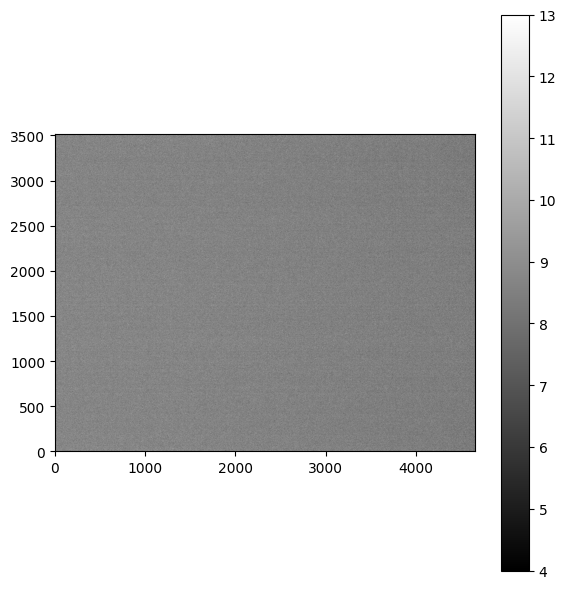

Exposure time :  3.2e-05  s


In [7]:
f_bias = base+"/bias_good//19_02_54/bias_good_00001.fits" 
bias, h_bias = read_data(f_bias)
show_image(bias, show=show)
print('Exposure time : ',h_bias['EXPTIME'],' s')

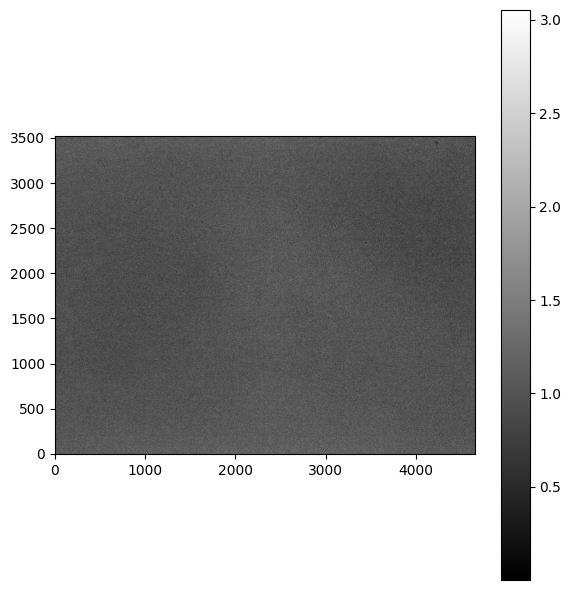

In [8]:
f_flat = base+"/Flat_V/20_19_43/Flat_V_00001.fits"
flat, h_flat = read_data(f_flat)
show_image(flat/np.nanmean(flat), show=show)

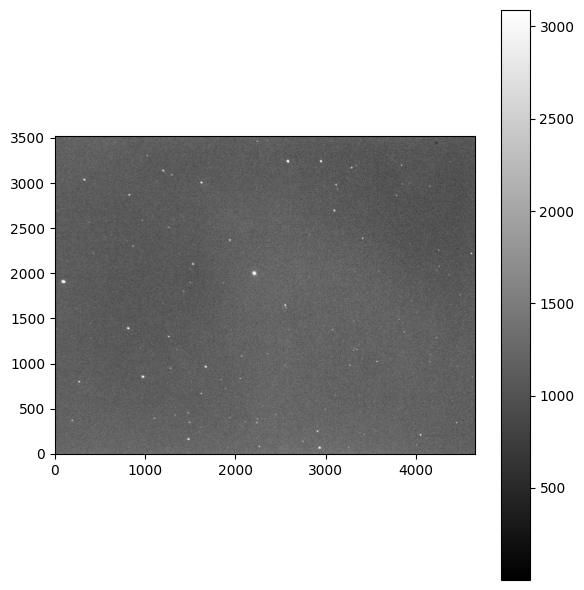

Exposure time :  2  s
Number of saturated pixels :  4656


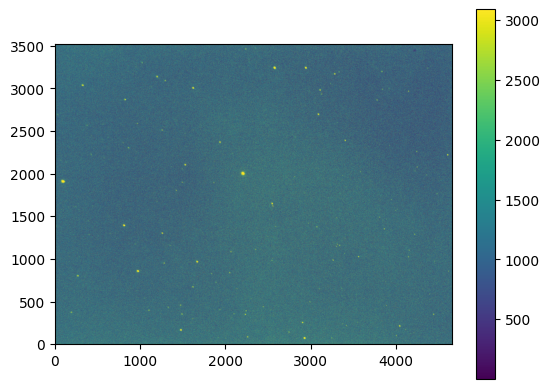

In [9]:
f_ciencia = base+"/toi4010_star/20_49_41/toi4010_star_00001.fits" 
science, h_science = read_data(f_ciencia)
show_image(science, show=show)
print('Exposure time : ',h_science['EXPTIME'],' s')
threshold = 60000
saturated_pixels = science>threshold
print('Number of saturated pixels : ',len(saturated_pixels[0]))

science_no_saturated = science
science_no_saturated[saturated_pixels] = np.nan
plt.imshow(science_no_saturated,vmin=np.nanpercentile(science_no_saturated,1),
           vmax=np.nanpercentile(science_no_saturated,99),origin='lower',cmap='viridis')
plt.colorbar()
plt.show()


In [10]:
import os
def read_set(f_base):
  f_names = os.listdir(f_base)
  data_list = []
  texp_list = []
  print(f_names)
  for f_name in f_names:
    if f_name[-5:]=='.fits':
      data,header = read_data(f_base+f_name)
      data_list.append(data)
      texp = header['EXPTIME']
      texp_list.append(texp)
  return np.array(data_list),np.array(texp_list)

In [11]:
base_bias = base+"/bias_good/19_02_54/"
bias_images,texp_bias = read_set(base_bias)
master_bias = np.nanmedian(bias_images,axis=0)

['bias_good_00001.CameraSettings.txt', 'bias_good_00001.fits', 'bias_good_00002.fits', 'bias_good_00003.fits', 'bias_good_00004.fits', 'bias_good_00005.fits', 'bias_good_00006.fits', 'bias_good_00007.fits', 'bias_good_00008.fits', 'bias_good_00009.fits', 'bias_good_00010.fits', 'desktop.ini']


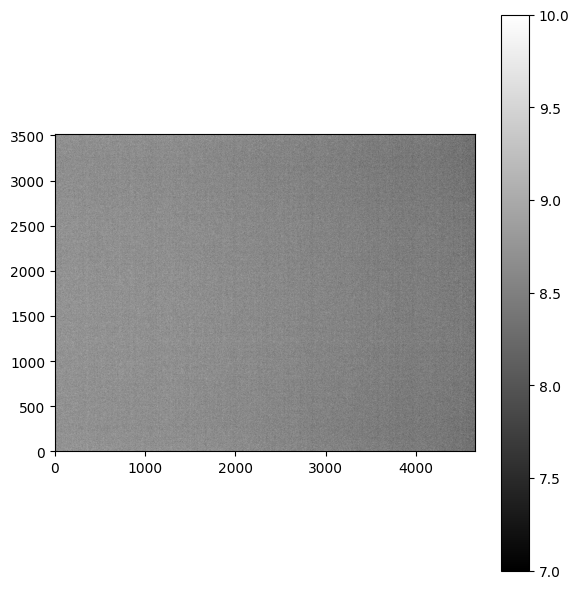

In [12]:
master_bias = np.nanmedian(bias_images,axis=0)
show_image(master_bias, show=show)

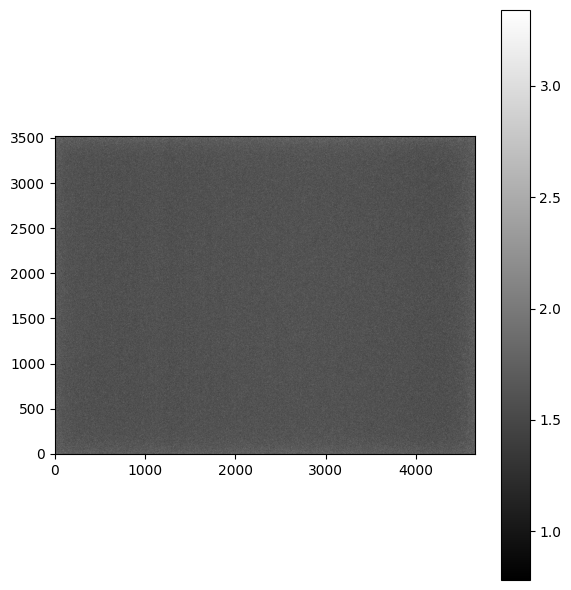

In [13]:
np.nanstd(master_bias[500:1500,500:1500])
np.nanstd(bias_images[0,:,:]-bias_images[1,:,:])
show_image(np.nanstd(bias_images,axis=0), show= show)

['Dark4s_00001.CameraSettings.txt', 'Dark4s_00001.fits', 'Dark4s_00002.fits', 'Dark4s_00003.fits', 'Dark4s_00004.fits', 'Dark4s_00005.fits', 'Dark4s_00006.fits', 'Dark4s_00007.fits', 'Dark4s_00008.fits', 'Dark4s_00009.fits', 'Dark4s_00010.fits', 'desktop.ini']
TEXP :  4


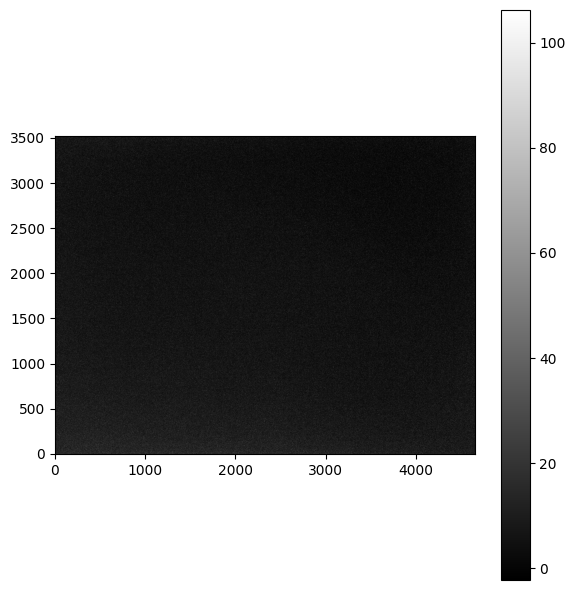

In [14]:
base_dark = base+"/Dark4s/21_38_02/" 

darks,texp =read_set(base_dark)
print("TEXP : ",texp[0] )
for i,dark in enumerate(darks):
  dark = dark
  darks[i] = (dark-master_bias)/(texp[i])*np.ones_like(darks[0])
master_dark = np.nanmedian(darks,axis=0)
show_image(master_dark, show=show) 

['desktop.ini', 'Flat_V_00001.CameraSettings.txt', 'Flat_V_00001.fits', 'Flat_V_00002.fits', 'Flat_V_00003.fits', 'Flat_V_00004.fits', 'Flat_V_00005.fits', 'Flat_V_00006.fits', 'Flat_V_00007.fits', 'Flat_V_00008.fits', 'Flat_V_00009.fits', 'Flat_V_00010.fits']


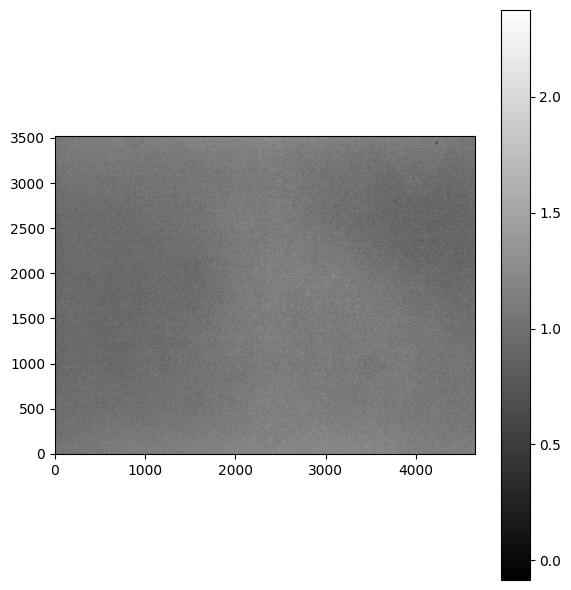

In [15]:
base_flat = base+"/Flat_V/20_19_43/"
flats, _  = read_set(base_flat)
from math import nan
for i , flat in enumerate(flats):
  flat = flat -master_bias - master_dark * texp[i]
  flats[i] = flat/np.nanmedian(flat)
master_flat_bad = np.nanmedian(flats,axis=0)
show_image(master_flat_bad, show=show)

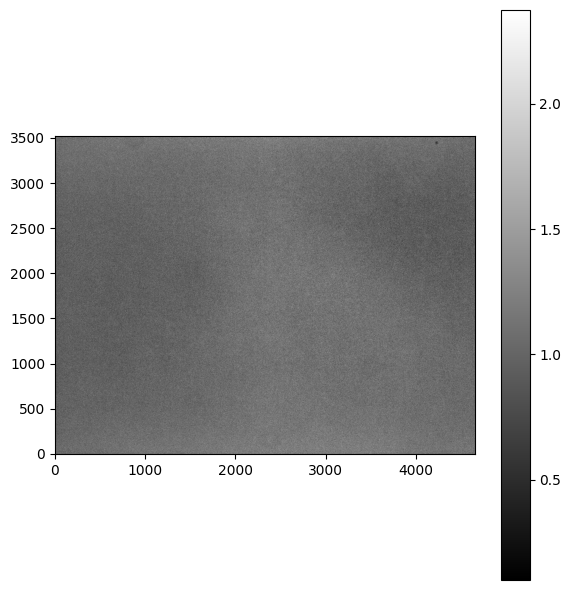

In [16]:
iden = np.where(master_flat_bad<0.1)
master_flat = master_flat_bad.copy()
master_flat[iden] = 0.1
show_image(master_flat, show=show)

['desktop.ini', 'toi4010_star_00001.CameraSettings.txt', 'toi4010_star_00001.fits', 'toi4010_star_00003.fits', 'toi4010_star_00004.fits', 'toi4010_star_00005.fits', 'toi4010_star_00006.fits', 'toi4010_star_00007.fits', 'toi4010_star_00008.fits', 'toi4010_star_00010.fits', 'toi4010_star_00011.fits', 'toi4010_star_00012.fits', 'toi4010_star_00013.fits', 'toi4010_star_00014.fits', 'toi4010_star_00015.fits', 'toi4010_star_00016.fits', 'toi4010_star_00018.fits']


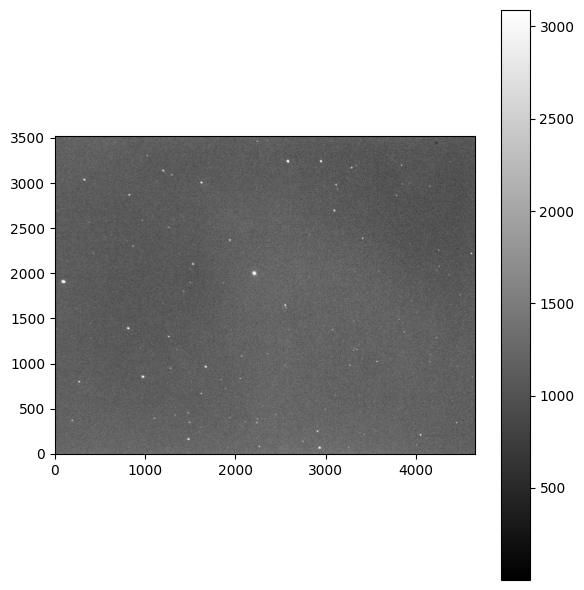

In [17]:
base_science = base+"/toi4010_star/20_49_41/"
science_raw,texp = read_set(base_science)
show_image(science_raw[0], show=show)

In [18]:
science_raw,texp = read_set(base_science)
science_calib = []
threshold = 60000
for i, science in enumerate(science_raw):
  science[science>threshold] = np.nan
  calib = (science -master_bias -texp[i]*master_dark)/(texp[i]*master_flat)
  calib = calib[1000:-1000, 1000:-1000]
  science_calib.append(calib)
science_calib = np.array(science_calib)
images = science_calib
l = len(images)

['desktop.ini', 'toi4010_star_00001.CameraSettings.txt', 'toi4010_star_00001.fits', 'toi4010_star_00003.fits', 'toi4010_star_00004.fits', 'toi4010_star_00005.fits', 'toi4010_star_00006.fits', 'toi4010_star_00007.fits', 'toi4010_star_00008.fits', 'toi4010_star_00010.fits', 'toi4010_star_00011.fits', 'toi4010_star_00012.fits', 'toi4010_star_00013.fits', 'toi4010_star_00014.fits', 'toi4010_star_00015.fits', 'toi4010_star_00016.fits', 'toi4010_star_00018.fits']


In [19]:
# for i in np.arange(l):
#     print(i+1)
#     show_image(science_calib[i], show=show)

In [20]:
# !pip install scikit-image

In [21]:
from scipy.spatial import KDTree
from skimage.measure import ransac
from skimage.transform import EuclideanTransform, SimilarityTransform, warp, AffineTransform
from astropy.stats import sigma_clipped_stats, mad_std
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.aperture import aperture_photometry, CircularAperture

image_ref= images[0]
mean, median, bkg_sigma = sigma_clipped_stats(image_ref, sigma=3.0)

daofind = DAOStarFinder(    fwhm=4.5,    threshold=10*bkg_sigma,    sharplo=0.3,    sharphi=1.5,    roundlo=-0.8,    roundhi=0.5)
sources_ref = daofind(image_ref)
if sources_ref is None:
    raise ValueError("No se encontraron estrellas en la imagen de referencia. Ajusta el threshold o FWHM.")
    
positions_ref = np.transpose((sources_ref['xcentroid'], sources_ref['ycentroid']))

aligned_images = []
aligned_images.append(image_ref)

tree = KDTree(positions_ref)
max_sep = 25.0 

len_img = len(images)
for i in np.arange(1,7):
    target_image = images[i]
    mean, median, bkg_sigma_i = sigma_clipped_stats(target_image, sigma=3.0)

    daofind_i = DAOStarFinder(fwhm = 4.5, threshold = 10*bkg_sigma_i, 
                              sharplo =0.3, sharphi =1.5, 
                              roundlo=-0.8, roundhi =0.5)

    sources_i = daofind_i(target_image)
    
    if sources_i is None:
        print(f"Img {i}: No se detectaron estrellas. Rellenando con NaNs.")
        aligned_images.append(np.full_like(image_ref, np.nan))
        continue
        
    target_positions = np.transpose((sources_i['xcentroid'], sources_i['ycentroid']))
    
    d, idx = tree.query(target_positions, distance_upper_bound=max_sep)
    valid_mask = d != np.inf
    
    src_pts = target_positions[valid_mask]      
    dst_pts = positions_ref[idx[valid_mask]]    
    
    if len(src_pts) < 3:
        print(f"Img {i}: Pocas estrellas ({len(src_pts)}). Saltando.")
        aligned_images.append(np.full_like(image_ref, np.nan))
        continue

    model_robust, inliers = ransac(
        (src_pts, dst_pts),
        AffineTransform,
        min_samples=3,
        residual_threshold=2.0, 
        max_trials=2000
    )
    
    use_translation_only = False
    
    if model_robust is None or np.sum(inliers) < 3:
        use_translation_only = True
    elif abs(np.degrees(model_robust.rotation)) > 3.0:
        print(f"Img {i}: Rotación excesiva ({np.degrees(model_robust.rotation):.1f}°). Forzando traslación pura.")
        use_translation_only = True

    if use_translation_only:
        diff = dst_pts - src_pts
        dx = np.median(diff[:, 0])
        dy = np.median(diff[:, 1])
        
        model_robust = SimilarityTransform(translation=(dx, dy))
        inliers = [True] * len(src_pts) 

    aligned_img_i = warp(
        target_image, 
        inverse_map=model_robust.inverse, 
        output_shape=image_ref.shape,
        order=1,
        cval=np.nan, 
        preserve_range=True
    )
    
    aligned_images.append(aligned_img_i)

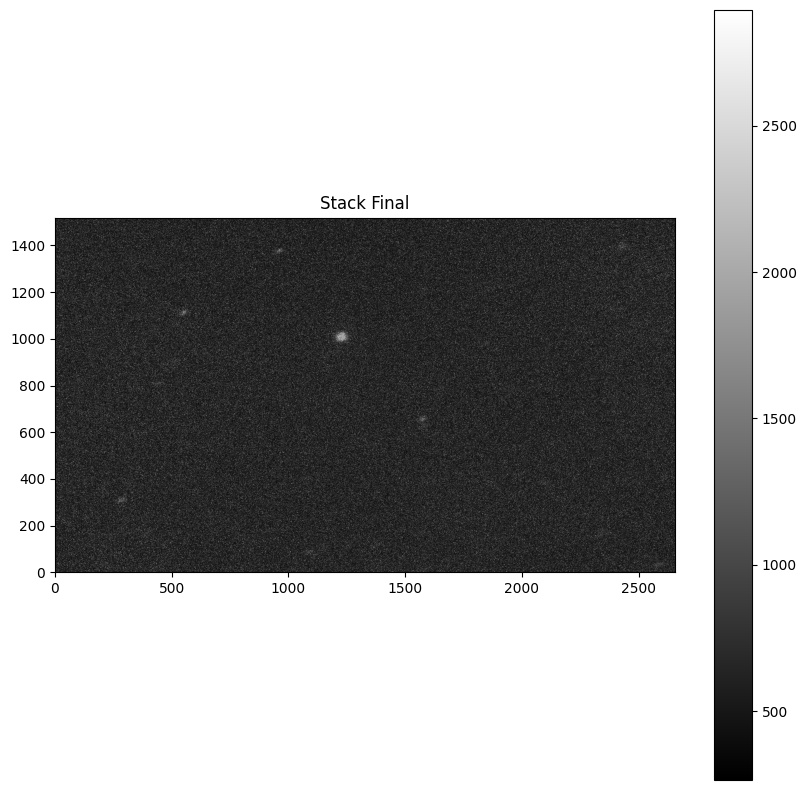

In [22]:
aligned_stack = np.array(aligned_images)

stacked = np.nanmedian(aligned_stack, axis=0)

plt.figure(figsize=(10, 10))


_, median_val_stck, std_val_stck  = sigma_clipped_stats(stacked, sigma=3.0, maxiters=5)

vmin = median_val_stck - 1 * std_val_stck
vmax = median_val_stck + 10 * std_val_stck

plt.imshow(stacked, origin='lower', vmin=vmin, vmax=vmax, cmap='grey')
plt.colorbar()
plt.title(f'Stack Final')
plt.show()

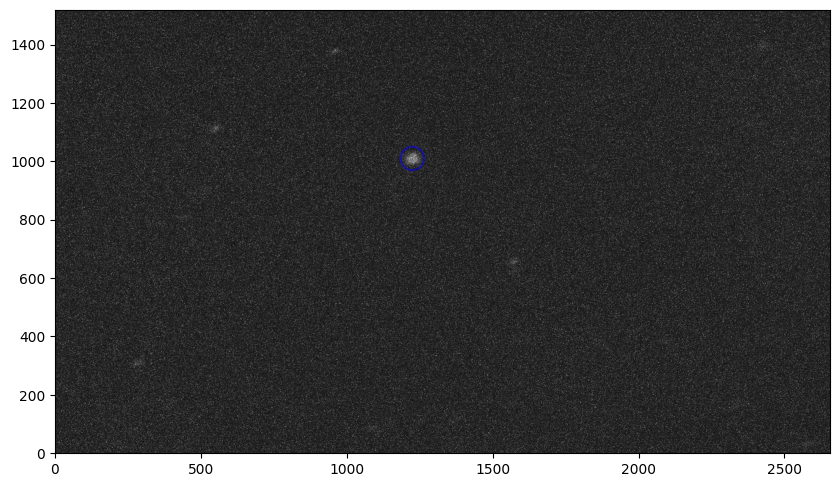

In [23]:
from scipy.ndimage import gaussian_filter
from photutils.aperture import CircularAnnulus, CircularAperture, aperture_photometry, ApertureStats
positions =[1225, 1010]
apertures = CircularAperture(positions, r=40.)
phot_table = aperture_photometry(stacked, apertures)
plt.figure(figsize=[10,10])
plt.imshow(stacked,cmap='gray',origin='lower',vmin=np.nanpercentile(stacked,1),vmax=np.nanpercentile(stacked,99))
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [24]:
len_p = np.size(positions)
len_p=int(len_p)

In [25]:
'''
from photutils.aperture import CircularAnnulus, CircularAperture, aperture_photometry, ApertureStats
#TODO: Muestra el recorte de la imagen de ciencia alrededor de una estrella

for i_star in np.arange(20, len_p):
    range = 30
    print(f"Estrella nº: {i_star}")
    x_star = int(positions[i_star,0])
    y_star = int(positions[i_star,1])
    star_image = ref_image[y_star-range:y_star+range,x_star-range:x_star+range]
    show_image(star_image, show=show)
''';

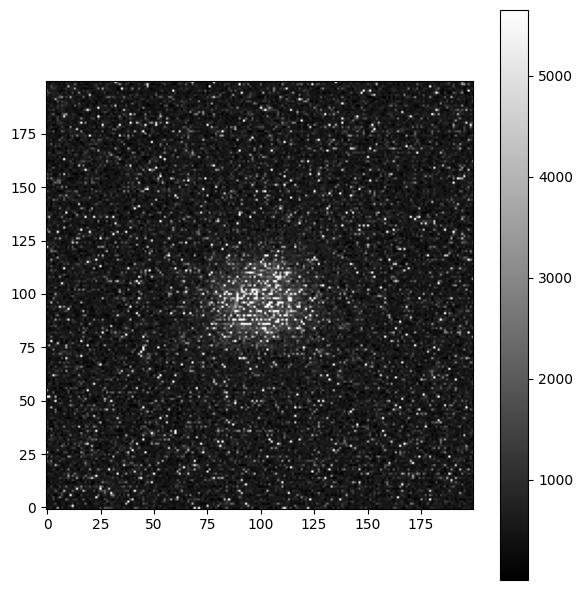

In [26]:
range = 100
x_star = int(positions[0])
y_star = int(positions[1])
star_image = stacked[y_star-range:y_star+range,x_star-range:x_star+range]
show_image(star_image, show=show)


 ----- La magnitud instrumental es -16.049 ----- 



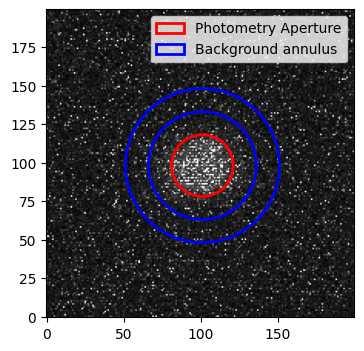

In [27]:
yp, xp = 98, 101  # y = fila, x = columna
xycen = np.array([xp, yp], dtype = float)
aperture = CircularAperture(xycen,r=20)
annulus_aperture = CircularAnnulus(xycen,r_in=35,r_out=50) 
plt.figure(figsize=[4,4],dpi=100)
plt.imshow(star_image,vmin=np.nanpercentile(star_image,1),
           vmax=np.nanpercentile(star_image,99),cmap='gray',origin='lower')
ap_patches = aperture.plot(color='red',lw=2,
                           label='Photometry Aperture')
ann_patches = annulus_aperture.plot(color='blue',lw=2,
                                    label='Background annulus')
background = ApertureStats(star_image,annulus_aperture).mean
total_flux = ApertureStats(star_image,aperture).sum
star_flux = total_flux - aperture.area* background
inst_mag=-2.5*np.log10(star_flux)
print(f"\n ----- La magnitud instrumental es {inst_mag:.3f} ----- \n")
plt.legend()
plt.show()

In [28]:
from scipy.optimize import curve_fit
def gauss(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0)**2/(2*sigma**2)) + c
cut = star_image
profile = np.sum(cut, axis=0)
xx = np.arange(len(profile))
p0 = [profile.max(), len(profile)/2, 2.0, profile.min()]
popt, _ = curve_fit(gauss, xx, profile, p0=p0)
sigma = popt[2]
fwhm = 2.355 * sigma

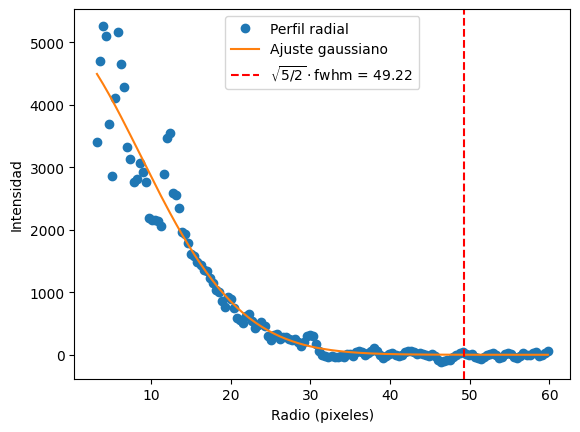

In [29]:
from photutils.profiles import RadialProfile
from astropy.modeling import models, fitting
radii = np.linspace(3, 60, 150)  
r_prof = RadialProfile(star_image-background, xycen,radii)
r=r_prof.radius
I=r_prof.profile

# Ajuste gaussiano
g_init = models.Gaussian1D(amplitude=I.max(), mean=0, stddev=2)
fit_g = fitting.LevMarLSQFitter()
g_fit = fit_g(g_init, r, I)


plt.plot(r, I, 'o', label='Perfil radial')
plt.plot(r, g_fit(r), '-', label='Ajuste gaussiano')
operation = r'$\sqrt{5/2} \cdot \mathrm{fwhm}$'
result = np.sqrt(5/2) * fwhm
plt.axvline(result, color='r', linestyle='--', label=f'{operation} = {result:.2f} ')
plt.xlabel('Radio (pixeles)')
plt.ylabel('Intensidad')
plt.legend()
plt.show()

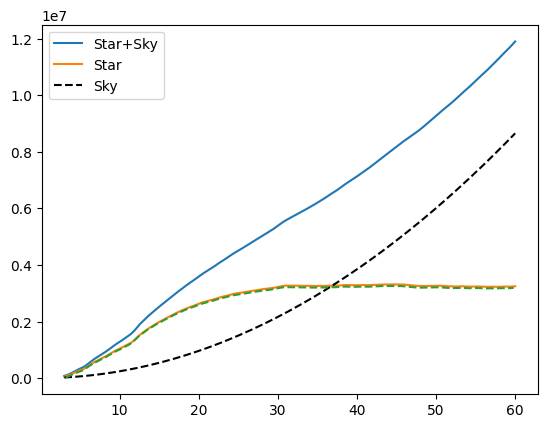

In [30]:
from photutils.profiles import CurveOfGrowth
cog = CurveOfGrowth(star_image,xycen=xycen, radii=radii)
cog_nobg =CurveOfGrowth(star_image-background,xycen=xycen, radii=radii)

plt.plot(cog.radius,cog.profile,label='Star+Sky')
plt.plot(cog_nobg.radius,cog_nobg.profile,label='Star')
plt.plot(cog.radius,cog.radius**2 *np.pi *background,linestyle='dashed',color='k',label='Sky')
plt.plot(r_prof.radius,2*np.pi*np.cumsum(r_prof.profile *r_prof.radius)*np.diff(radii),linestyle='dashed',color='tab:green')
plt.legend()

In [31]:
def gaia_to_I(G,Gbp,Grp):
  color = Gbp - Grp
  return G -0.01753 -0.76*color +0.0991*color**2
def gaia_to_R(G,Gbp,Grp):
  color = Gbp - Grp
  return G +0.02275 -0.3961*color +0.1243*color**2 +0.01396*color**3 -0.003775*color**4
def gaia_to_V(G,Gbp,Grp):
  color = Gbp - Grp
  return G +0.02704 -0.01424*color +0.2156*color**2 -0.01426*color**3

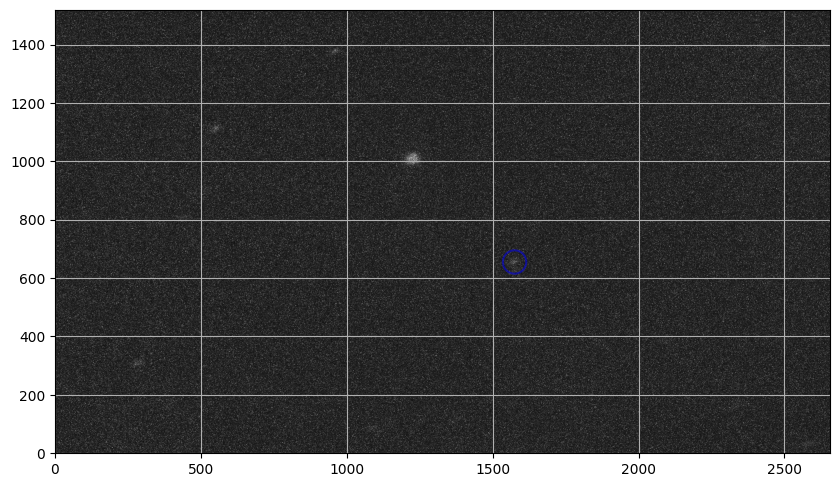

In [32]:
positions =[1575, 655]
apertures = CircularAperture(positions, r=40.)
phot_table = aperture_photometry(stacked, apertures)
plt.figure(figsize=[10,10])
plt.imshow(stacked,cmap='gray',origin='lower',vmin=np.nanpercentile(stacked,1),vmax=np.nanpercentile(stacked,99))
plt.grid()
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

0,28 arcs por pixeles 

In [33]:
# len_p = np.size(positions[:,0])
# len_p=int(len_p)

# for i_star in np.arange(len_p):
#     range = 30
#     print(f"Estrella nº: {i_star}")
#     x_star = int(positions[i_star,0])
#     y_star = int(positions[i_star,1])
#     star_image = ref_image[y_star-range:y_star+range,x_star-range:x_star+range]
#     show_image(star_image, show=show)


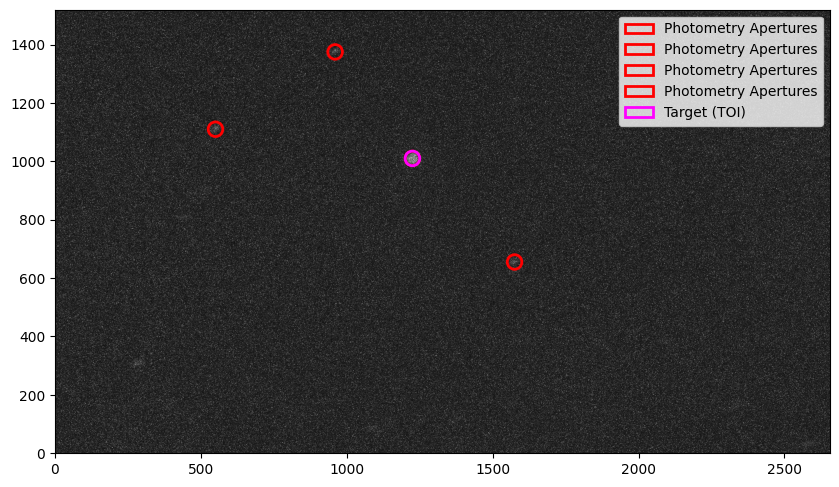

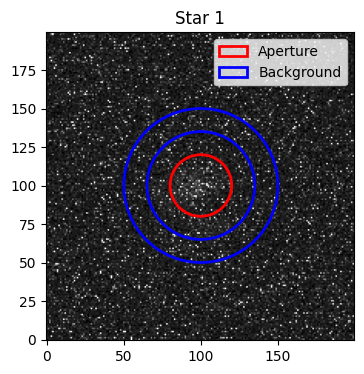

--- Star 1 ---
FWHM : 16.4423 pixels
Average sky flux : 736.4445 counts/s/pixel
Star flux (net)  : 307159.4086 counts/s
Instrumental Mag : -13.7184
V band Magnitude : 14.1542




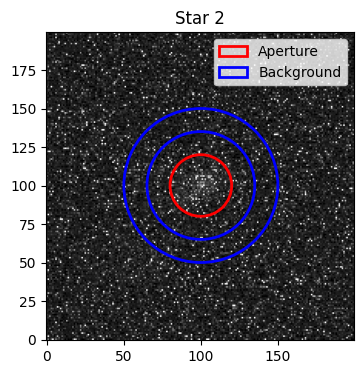

--- Star 2 ---
FWHM : 14.2763 pixels
Average sky flux : 693.8186 counts/s/pixel
Star flux (net)  : 441331.2346 counts/s
Instrumental Mag : -14.1119
V band Magnitude : 14.9701




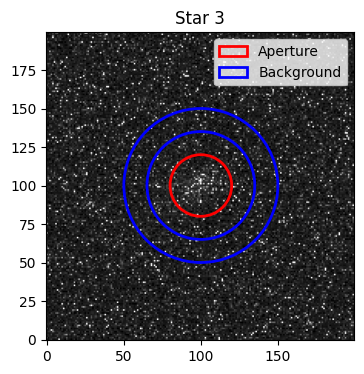

--- Star 3 ---
FWHM : 14.9499 pixels
Average sky flux : 657.9165 counts/s/pixel
Star flux (net)  : 333442.4944 counts/s
Instrumental Mag : -13.8076
V band Magnitude : 13.6053




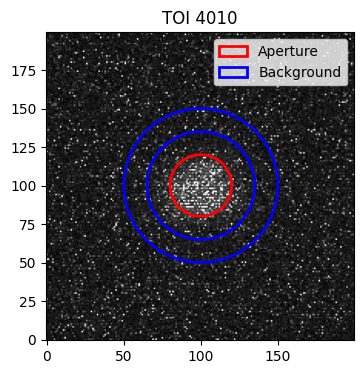

--- TOI 4010 ---
FWHM : 28.3407 pixels
Average sky flux : 766.8226 counts/s/pixel
Star flux (net)  : 2584223.0510 counts/s
Instrumental Mag : -16.0308




In [99]:
half_size = 100 
r_aperture = 20
r_in = 35
r_out = 50

coords = {
    'Star 1': (1575, 655),
    'Star 2': (550, 1110),
    'Star 3': (960, 1375),
    'TOI 4010': (1225, 1010)
}

gaia_data = {
    'Star 1': (12.9854, 14.4017, 11.8361),
    'Star 2': (14.4881, 15.2125, 13.6406),
    'Star 3': (13.2335, 13.8454, 12.4829),
    'TOI 4010': (None, None, None) 
}

plt.figure(figsize=[10, 10], dpi=100)
plt.imshow(stacked, 
           vmin=np.nanpercentile(stacked, 1),
           vmax=np.nanpercentile(stacked, 99), 
           cmap='gray', origin='lower')

positions_list = list(coords.values())
apertures_global = CircularAperture(positions_list, r=25)
apertures_global.plot(color='red', lw=2, label='Photometry Apertures')

aperture_TOI_global = CircularAperture(coords['TOI 4010'], r=25)
aperture_TOI_global.plot(color='fuchsia', lw=2, label='Target (TOI)')

plt.legend()
plt.savefig('')
plt.show()

def analyze_star(name, global_pos, gaia_tuple, image_stack):
    x_g, y_g = global_pos
    
    y_min, y_max = int(y_g - half_size), int(y_g + half_size)
    x_min, x_max = int(x_g - half_size), int(x_g + half_size)
    star_stamp = image_stack[y_min:y_max, x_min:x_max]
    
    local_center = (half_size, half_size)
    
    ap_local = CircularAperture(local_center, r=r_aperture)
    ann_local = CircularAnnulus(local_center, r_in=r_in, r_out=r_out)
    
    ap_global = CircularAperture(global_pos, r=r_aperture)
    ann_global = CircularAnnulus(global_pos, r_in=r_in, r_out=r_out)

    plt.figure(figsize=[4, 4], dpi=100)
    plt.title(name)
    plt.imshow(star_stamp, 
               vmin=np.nanpercentile(star_stamp, 1),
               vmax=np.nanpercentile(star_stamp, 99), 
               cmap='gray', origin='lower')
    
    ap_local.plot(color='red', lw=2, label='Aperture')
    ann_local.plot(color='blue', lw=2, label='Background')
    plt.legend()
    plt.show()
    
    stats_sky = ApertureStats(image_stack, ann_global)
    bkg_mean = stats_sky.mean

    stats_star = ApertureStats(image_stack, ap_global)
    total_flux = stats_star.sum
    fondo_flux = ap_global.area * bkg_mean
    
    star_flux = total_flux - fondo_flux
    
    inst_mag = -2.5 * np.log10(star_flux)
    
    radii = np.arange(1, 25)
    rp = RadialProfile(star_stamp - bkg_mean, local_center, radii, mask=None)
    
    v_mag = np.nan
    if gaia_tuple[0] is not None:
        v_mag = gaia_to_V(*gaia_tuple)

    print(f"--- {name} ---")
    print(f"FWHM : {rp.gaussian_fwhm:.4f} pixels")
    print(f"Average sky flux : {bkg_mean:.4f} counts/s/pixel")
    print(f"Star flux (net)  : {star_flux:.4f} counts/s")
    print(f"Instrumental Mag : {inst_mag:.4f}")
    if gaia_tuple[0] is not None:
        print(f"V band Magnitude : {v_mag:.4f}")
    print("\n")

    return star_flux, inst_mag, v_mag, ap_global, total_flux, fondo_flux

flux_list = []
mag_inst_list = []
mag_v_list = []
names_list = []
ap_global_list = []
total_flux_list = []
fondo_flux_list = []


for name, pos in coords.items():
    f, m_inst, m_v, ap_gb, tot_fx, fondo_fx = analyze_star(name, pos, gaia_data[name], stacked)
    flux_list.append(f)
    mag_inst_list.append(m_inst)
    mag_v_list.append(m_v)
    names_list.append(name)
    ap_global_list.append(ap_gb)
    total_flux_list.append(tot_fx)
    fondo_flux_list.append(fondo_fx)
    

flux_vector = np.array(flux_list)
mag_inst_vector = np.array(mag_inst_list)
mag_inst_vector_FIN = mag_inst_vector[0:3]
mag_v_vector = np.array(mag_v_list)
mag_v_vector_FIN = mag_v_vector[0:3]
names_vector = np.array(names_list)
ap_global_vector = np.array(ap_global_list)
aperture_flux_vector = np.array(total_flux_list)
fondo_flux_vector = np.array(fondo_flux_list)

In [126]:
m_inst = mag_inst_vector_FIN
V_tab = mag_v_vector_FIN
C_V_i = V_tab - m_inst
C_V = np.mean(C_V_i)
std_dev_s = np.std(C_V_i, ddof = 1) #Desviación estándar no sesgada YA QUE N <= 10
sig_C_V = std_dev / np.sqrt(len(C_V_i)) 
err_C_V = sig_C_V

print("The constant of the V band will be: ", np.round(C_V,4)," +/- ",np.round(sig_C_V,10))

The constant of the V band will be:  28.1225  +/-  0.4977712237


In [37]:
mobj = inst_mag + float(C_V)
print(mobj)

12.073071386587287


CÁLCULO DE ERRORES

In [54]:
hdu[0].header

SIMPLE  =                    T / C# FITS: 11/06/2025 20:49:41                   
BITPIX  =                   16                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 4656                                                  
NAXIS2  =                 3520                                                  
OBJECT  = 'toi4010_star'       /                                                
GAIN    =                  600 /                                                
FILTER  = 'Filter 1'           /                                                
DATE-AVG= '2025-11-06T19:49:40.1333121' / System Clock:Est. Frame Mid Point     
DATE-END= '2025-11-06T19:49:41.1333121' / System Clock:Est. Frame End           
DATE-OBS= '2025-11-06T19:49:39.1333121' / System Clock:Est. Frame Start         
SWCREATE= 'SharpCap v4.0.8218.0, 64 bit' /                                      
FRAMETYP= 'Light   '        

In [117]:
g = 0.005
N_r= 1.2       
N_img= 6   

med_pref = np.sqrt(np.pi/2) /np.sqrt(N_img)

F_ap =  aperture_flux_vector[3]
F_fond = fondo_flux_vector[3]
n_pix = ap_global_vector[3].area #da igual que cojamos 0,1,..,3 pq todos mismo area, cojo 3 para seguir siempre lo mismo, en el resto SI importa


err_ap = F_ap/g
err_fd = F_fond/g
err_r2 = n_pix * N_r**2  / g**2

err_star = med_pref * np.sqrt(err_ap+err_fd+err_r2)


err_mint = 2.5 * err_star /(flux_vector[3]* np.log(10))

In [128]:
err_m = np.sqrt(err_mint**2 + err_C_V**2)
err_m

np.float64(0.4978164651668318)